In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import norm
from scipy.integrate import trapezoid
import seaborn as sns

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


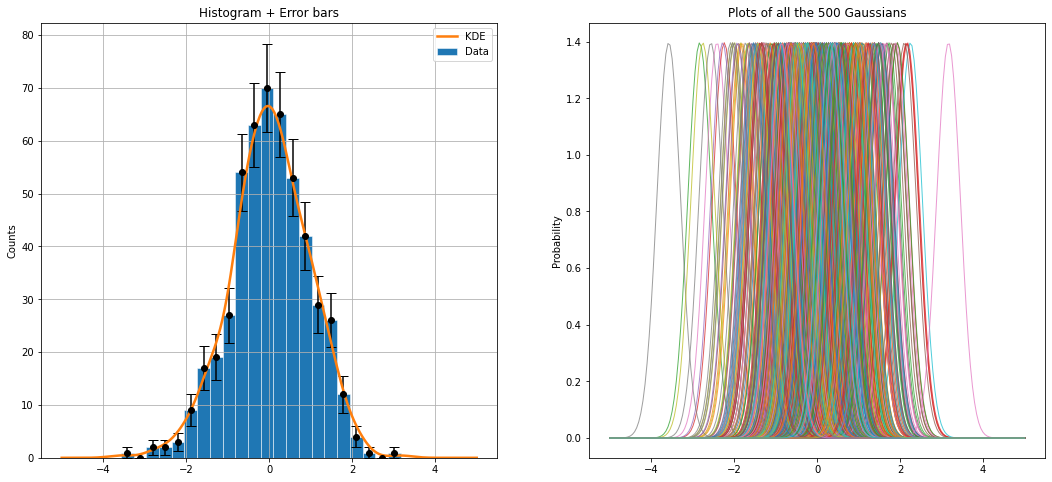

In [15]:
N = 500
mu, sigma = 0, 1
x = sigma * np.random.randn(N) + mu

# histogram and error bars
fig, axs = plt.subplots(1,2, figsize=(18,8))
axs[0].set_ylabel("Counts")
hn, hbin, _ = axs[0].hist(x, bins=round(np.sqrt(N)), label='Data', color='C0',\
                          linewidth=0.5, edgecolor="white")
axs[0].grid()
axs[0].errorbar((hbin[1:]+hbin[:-1])*0.5, hn, np.sqrt(hn), fmt='o', capsize=5, color='black')
axs[0].set_title("Histogram + Error bars")

# display only the integer ytick labels
axs[0].set_yticks(axs[0].get_yticks()[axs[0].get_yticks()%1 == 0])


# create a vector of Gaussians
stdef = 1.06*x.std()*(x.size**(-1/5))
norms = [norm(loc=xmu, scale=stdef) for xmu in x]
x0 = np.linspace(-5,5,200)

# plot all the Gaussian's PDFs
axs[1].set_ylabel("Probability")
axs[1].set_title("Plots of all the "+str(N)+" Gaussians")
for k in norms:
    axs[1].plot(x0, k.pdf(x0), alpha=0.75, linewidth=1)

# get the (normalized) sum of all the gaussians and plot the result
nsum = np.sum([k.pdf(x0) for k in norms], axis=0)
A = (np.sum((hbin[1:]-hbin[:-1]) * hn) / trapezoid(nsum, x0))
nsum *= A
axs[0].plot(x0, nsum, color='C1', label='KDE', linewidth=2.5)
axs[0].legend()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [ ]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [16]:
def catgen (Nsamp=1000, Ncat=2, low_mu=-5.0, high_mu=5.0, high_sigma=1.0):
    """
    This function generates the 2D dataset with 'Ncat' categories (default value is 2).
    For  each category, 'Nsamp' samples are randomly chosen from the corresponding 2D Gaussian (default is 1000).
    The means and stds of the 'Ncat' Gaussians are chosen uniformly from a range [low_mu, high_mu]
    and [0, high_sigma] respectively.
    For simplicity, the covariance matrices of all the Gaussians are proportional to the identity matrix.
    
    The output dataframe has the columns ['X','Y','CATEGORY'] and has (Nsamp * Ncat) rows.
    """
    
    # generate random means and stds
    mus = np.random.uniform(low=low_mu, high=high_mu, size=(Ncat,2))
    sigmas = np.random.uniform(low=0, high=high_sigma, size=Ncat)
    
    # random generator
    rng = np.random.default_rng()
    
    # initialize dataframe containing all the data
    df = pd.DataFrame(columns=['X','Y','CATEGORY'])
    
    # generate samples for every category
    # and update the dataframe
    for j in range(Ncat):
        norm2D = rng.multivariate_normal(mean=mus[j,:], cov=sigmas[j]*np.identity(2), size=Nsamp)
        cat_data = np.concatenate((norm2D, np.full(shape=(Nsamp,1), fill_value=j)), axis=1)
        df = pd.concat([df, pd.DataFrame(data=cat_data, columns=df.columns)], ignore_index=True)
        
    return df
    

,X,Y,CATEGORY,COLOR
0,4.593846,1.958839,0.0,C0
1,5.067514,0.817633,0.0,C0
2,3.672376,2.883380,0.0,C0
3,4.422398,1.457525,0.0,C0
4,3.984975,1.232143,0.0,C0
...,...,...,...,...
2995,-4.373657,-3.363730,2.0,C2
2996,-4.731397,-3.130663,2.0,C2
2997,-3.981299,-3.245258,2.0,C2
2998,-3.949582,-1.017350,2.0,C2


<AxesSubplot:title={'center':'Color-Coded Scatter Plot'}, xlabel='X', ylabel='Y'>

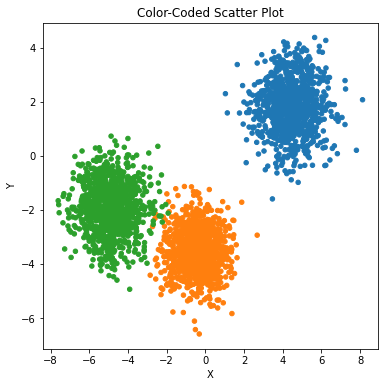

In [17]:
# dataframe with 3 categories and the other parameters chosen as default
data = catgen(Ncat=3)

# set up scatter plot
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.set_ylabel("Y")
ax.set_xlabel("X")
ax.set_title("Color-Coded Scatter Plot")

# add a column to specify the color
data['COLOR'] = data['CATEGORY'].map(lambda x: 'C'+str(round(x)))
display(data)

# plot
data.plot.scatter(x='X', y='Y',c='COLOR', ax=ax)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [18]:
# import and display the dataset
data = pd.DataFrame(np.load("residuals_261.npy", allow_pickle=True).item())
display(data)

# filter the dataset
data = data[np.abs(data['residuals']) < 2]

# perform linear regression of "residuals" (on y) versus "distances" (on x)
res_linreg = st.linregress(data.values[:,::-1])
labl = 'y = '+str(round(res_linreg.slope,4))+' * x + ' + str(round(res_linreg.intercept,4))

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


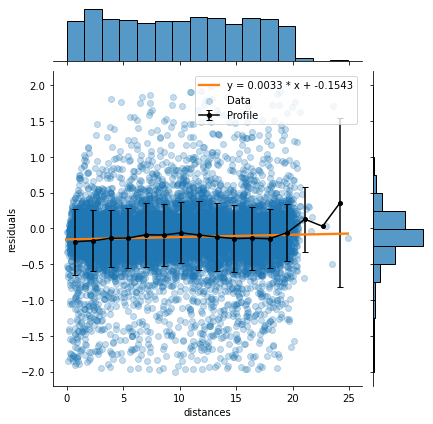

In [20]:
# plot jointplot of 'residuals' vs 'distances' with scatter plot and linear
# regression and two marginal histograms
Nbin = 16
g = sns.JointGrid(data=data, x='distances', y='residuals')
axj = g.ax_joint
g.plot_marginals(sns.histplot, bins=Nbin)
g.plot_joint(sns.regplot, label='Data',\
             scatter_kws={'alpha':0.25, 'color':'C0'},\
             line_kws={'color':'C1', 'label':labl})


# create edges of the bins and bin positions
x0 = np.linspace(start=0, stop=25, num=Nbin+1)
x = (x0[1:]+x0[:-1]) * 0.5

# compute mean and std over each bin
bindata = pd.concat([data, pd.cut(data['distances'], x0)], axis=1)
bindata.columns=['residuals','distances','bin']
bingroups = bindata.groupby('bin')
y = bingroups.mean()['residuals'].values
erry = bingroups.std()['residuals'].values

# plot errorbar
axj.errorbar(x=x, y=y, yerr=erry, color='black', label='Profile', capsize=3, marker='o', markersize=4)

# draw legend
axj.legend()